In [1]:
%matplotlib nbagg
import jungfrau_utils as ju
import numpy as np
import json
import os, glob
import time
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import cm
from scipy.optimize import curve_fit
from IPython.display import clear_output, display
import matplotlib.colors as colors

import h5py
from ipyfilechooser import FileChooser

from alvra_tools import *
from alvra_tools.channels import *
#from alvra_tools.channels_raw import *
from scipy.stats.stats import pearsonr

In [17]:
scan_name ="Co_YIG_delayscan_Fe_014"
DIR_json = "/sf/alvra/data/p18741/raw/scan_info/"
DIR = "/sf/alvra/data/p18741/raw/" + scan_name + "/"             #use this for a scan

#######################################################################

!ls -lah -rt $DIR | grep h5
!hostname

-rw-r--r--.   1 root p18741 2.0G Dec 11 11:31 run_002756.JF04T01V01.h5
-rw-r--r--.   1 root p18741 2.0G Dec 11 11:31 run_002756.JF10T01V01.h5
-rw-r--r--.   1 root p18741 2.0G Dec 11 11:32 run_002757.JF10T01V01.h5
-rw-r--r--.   1 root p18741 2.0G Dec 11 11:32 run_002757.JF04T01V01.h5
-rw-r--r--.   1 root p18741 2.0G Dec 11 11:32 run_002758.JF04T01V01.h5
-rw-r--r--.   1 root p18741 2.0G Dec 11 11:32 run_002758.JF10T01V01.h5
-rw-r--r--.   1 root p18741 2.0G Dec 11 11:32 run_002759.JF10T01V01.h5
-rw-r--r--.   1 root p18741 2.0G Dec 11 11:32 run_002759.JF04T01V01.h5
-rw-r--r--.   1 root p18741 228M Dec 11 11:33 run_002756.BSREAD.h5
-rw-r--r--.   1 root p18741 2.0G Dec 11 11:33 run_002760.JF10T01V01.h5
-rw-r--r--.   1 root p18741 2.0G Dec 11 11:33 run_002760.JF04T01V01.h5
-rw-r--r--.   1 root p18741 228M Dec 11 11:33 run_002757.BSREAD.h5
-rw-r--r--.   1 root p18741  78M Dec 11 11:33 run_002756.BSDATA.h5
-rw-r--r--.   1 root p18741 2.0G Dec 11 11:33 run_002761.JF04T01V01.h5
-rw-r--r--.   1 ro

ra-c-001.psi.ch


In [18]:
f ="run_002777*.h5"
fn = DIR + f

channel_list = [channel_Izero117, channel_Izero122, channel_energy, 'JF04T01V01','JF10T01V01']

results = load_data_compact(channel_list, fn)

Energy_shot   = results[channel_energy]
IzeroFEL117_shot = results[channel_Izero117]
IzeroFEL122_shot = results[channel_Izero122]
#DataFluoPIPS_shot = - results[channel_PIPS_trans]
DataFluoJFimage_shot = results ['JF04T01V01']

Auto-located gain file: /sf/alvra/config/jungfrau/gainMaps/JF04T01V01/gains.h5
Auto-located pedestal file: /sf/alvra/data/p18741/raw/JF_pedestals/run_001060.JF04T01V01.res.h5
jungfrau file: 11:39 11.12.2020
pedestal file: 11:45 10.12.2020
    mtime difference: 23:54:08.294961
Auto-located gain file: /sf/alvra/config/jungfrau/gainMaps/JF10T01V01/gains.h5
Auto-located pedestal file: /sf/alvra/data/p18741/raw/JF_pedestals/run_001060.JF10T01V01.res.h5
jungfrau file: 11:39 11.12.2020
pedestal file: 11:45 10.12.2020
    mtime difference: 23:54:03.375463

--------------------------------------------------------------------------------

JF04T01V01                        2000 / 2000 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
JF10T01V01                        2000 / 2000 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SAR-CVME-TIFALL5:EvtSet           2000 / 2000 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SAROP11-PBPS117:INTENSITY         1937 / 2000 -> 3% loss ▇▇▇▇▇▇▇▇▇
SAROP11-PBPS122:INTENSITY         2000 / 2000 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SLAAR11-LTIM01-EVR0:DUMM

/das/work/p18/p18741/anaconda/alvra-analysis-p18741/lib/python3.6/site-packages/jungfrau_utils/data_handler.py:519: RuntimeWarning: 'gap_pixels' flag has no effect on stripsel detectors
  warnings.warn("'gap_pixels' flag has no effect on stripsel detectors", RuntimeWarning)


## JF and Izero

Energy = 7118.0652097155025 eV
Median value Izero (all) = 0.1560030896216631
Median value fluo (all) = 0.11643920093774796
correlation = 0.9958530711245461


<IPython.core.display.Javascript object>


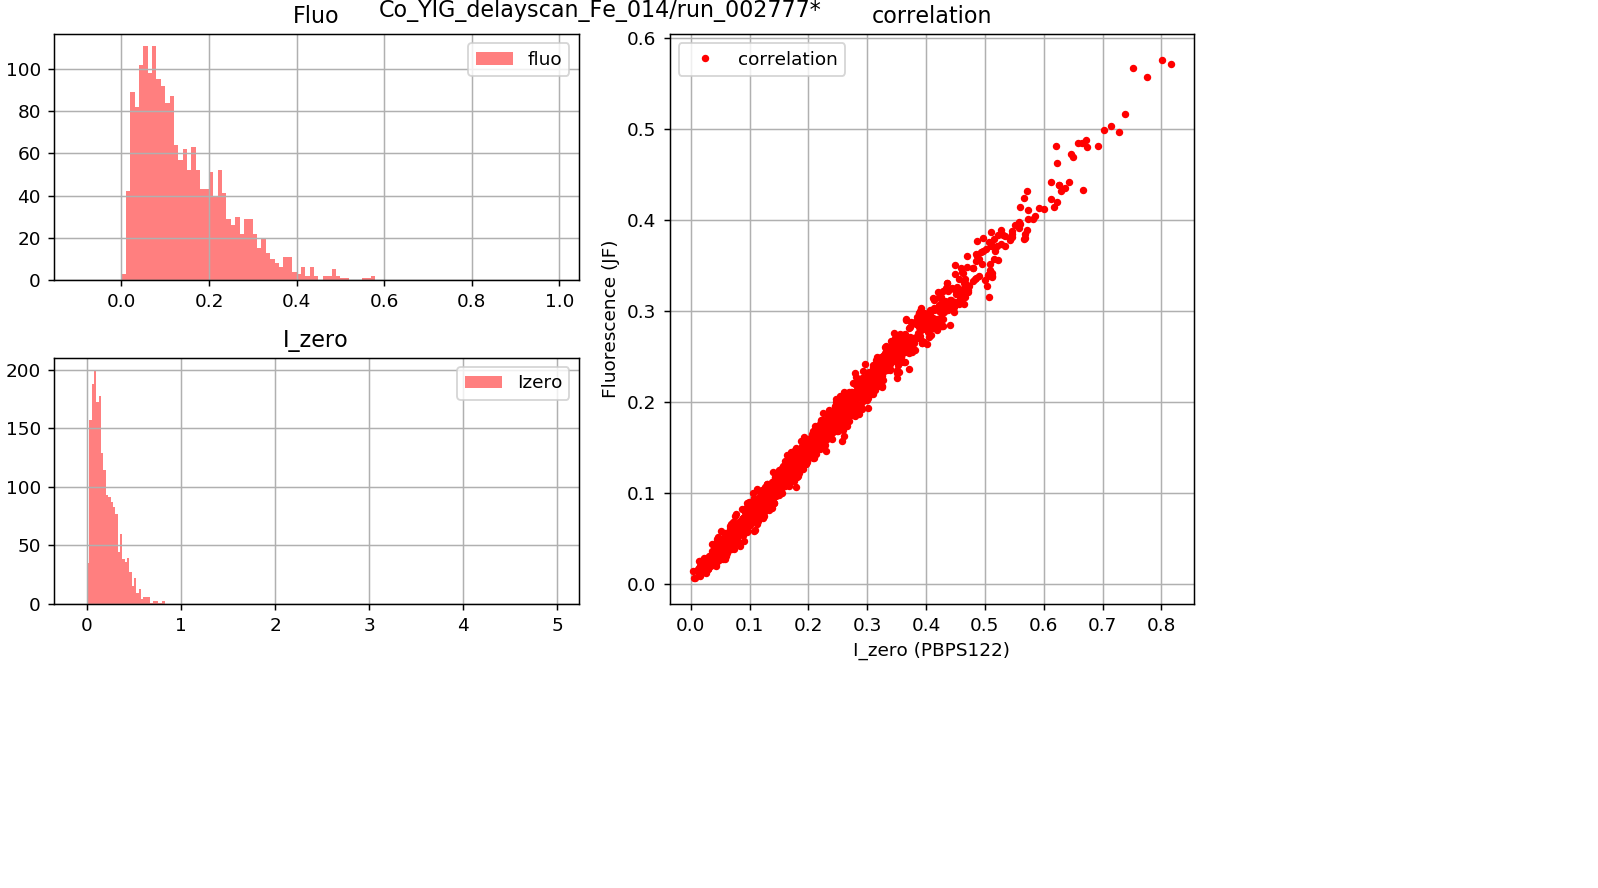

In [26]:
threshold_low = 5.5
threshold_high = 10

pid_roll = 0

nframes = DataFluoJFimage_shot.shape[0]
DataFluoJFimage_shot_thr = DataFluoJFimage_shot.copy()

for j in range(nframes):
    image = DataFluoJFimage_shot[j,:]
    image_thr = DataFluoJFimage_shot[j,:].copy()
    image_thr[image < threshold_low] = 0
    image_thr[image > threshold_high] = 0
    DataFluoJFimage_shot_thr[j,:] = image_thr.copy()

IzeroFEL_shot = IzeroFEL122_shot.copy()

DataFluoJF_shot = np.roll(DataFluoJFimage_shot_thr.mean(axis = 1).mean(axis = 1), pid_roll, axis = 0)
DataFluoJF_shot_raw = DataFluoJF_shot.copy()

print ("Energy = {} eV".format(np.median(Energy_shot)))
print ("Median value Izero (all) = {}".format(np.median(IzeroFEL_shot)))
print ("Median value fluo (all) = {}".format(np.median(DataFluoJF_shot_raw)))
print ("correlation = {}".format(pearsonr(IzeroFEL_shot,DataFluoJF_shot)[0]))

fig = plt.figure(constrained_layout=True, figsize=(9,5))
plt.suptitle(scan_name +"/"+ f.split('.')[0], y = 1)
gs = fig.add_gridspec(2, 2)

f_ax1 = fig.add_subplot(gs[0, :-1])
f_ax1.set_title('Fluo')
plt.hist(DataFluoJF_shot, bins =np.arange(-0.1,1,0.01), facecolor='red', label="fluo", alpha=0.5)
plt.grid()
plt.legend(loc="best")

f_ax2 = fig.add_subplot(gs[1, :-1])
f_ax2.set_title('I_zero')
plt.hist(IzeroFEL_shot, bins =np.arange(-0.1,5,0.025), facecolor='red', label='Izero', alpha=0.5)
plt.grid()
plt.legend(loc="best")

f_ax3 = fig.add_subplot(gs[0:, 1])
f_ax3.set_title('correlation')
plt.plot(IzeroFEL_shot, DataFluoJF_shot, color = 'red',  linestyle='None', label='correlation',marker='.')
plt.grid()
plt.legend(loc="best")
plt.xlabel("I_zero (PBPS122)")
plt.ylabel ("Fluorescence (JF)")

plt.show()

## JF with itself

Energy = 7118.0652097155025 eV
Median value Izero (all) = 0.03060794249176979
Median value fluo (all) = 0.11023804545402527
correlation = 0.9977307173471908


<IPython.core.display.Javascript object>


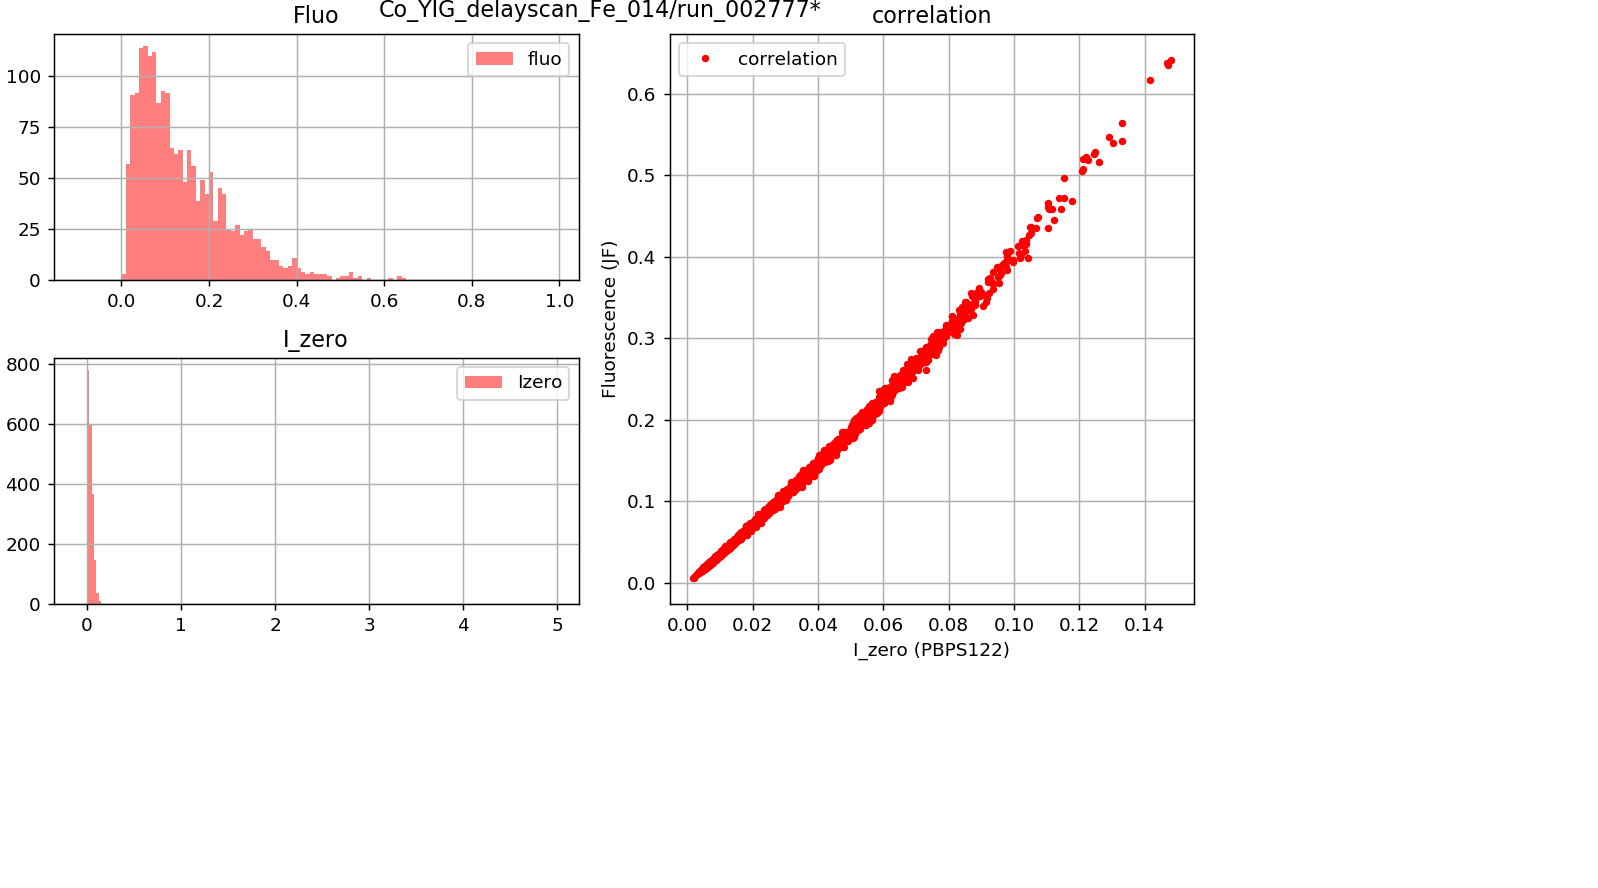

In [28]:
threshold_low = 6.0
threshold_high = 100

threshold_I0_low = 2
threshold_I0_high = 5

nframes = DataFluoJFimage_shot.shape[0]
DataFluoJFimage_shot_thr = np.empty_like(DataFluoJFimage_shot)
IzeroFEL_shot_JF_thr = np.empty_like(DataFluoJFimage_shot)

for j in range(nframes):
    image = DataFluoJFimage_shot[j,:]
    image_I0 = DataFluoJFimage_shot[j,:]
    
    image_thr = np.copy(DataFluoJFimage_shot[j,:])
    image_I0_thr = np.copy(DataFluoJFimage_shot[j,:])
    
    image_thr[image < threshold_low] = 0
    image_thr[image > threshold_high] = 0
    
    image_I0_thr[image_I0 < threshold_I0_low] = 0
    image_I0_thr[image_I0 > threshold_I0_high] = 0
    
    DataFluoJFimage_shot_thr[j,:] = image_thr.copy()
    IzeroFEL_shot_JF_thr[j,:] = image_I0_thr.copy()

IzeroFEL_shot = IzeroFEL_shot_JF_thr.mean(axis = 1).mean(axis = 1)
DataFluoJF_shot = DataFluoJFimage_shot_thr.mean(axis = 1).mean(axis = 1)

DataFluoJF_shot_raw = DataFluoJF_shot.copy()

print ("Energy = {} eV".format(np.median(Energy_shot)))
print ("Median value Izero (all) = {}".format(np.median(IzeroFEL_shot)))
print ("Median value fluo (all) = {}".format(np.median(DataFluoJF_shot_raw)))
print ("correlation = {}".format(pearsonr(IzeroFEL_shot,DataFluoJF_shot)[0]))

fig = plt.figure(constrained_layout=True, figsize=(9,5))
plt.suptitle(scan_name +"/"+ f.split('.')[0], y = 1)
gs = fig.add_gridspec(2, 2)

f_ax1 = fig.add_subplot(gs[0, :-1])
f_ax1.set_title('Fluo')
plt.hist(DataFluoJF_shot, bins =np.arange(-0.1,1,0.01), facecolor='red', label="fluo", alpha=0.5)
plt.grid()
plt.legend(loc="best")

f_ax2 = fig.add_subplot(gs[1, :-1])
f_ax2.set_title('I_zero')
plt.hist(IzeroFEL_shot, bins =np.arange(-0.1,5,0.025), facecolor='red', label='Izero', alpha=0.5)
plt.grid()
plt.legend(loc="best")

f_ax3 = fig.add_subplot(gs[0:, 1])
f_ax3.set_title('correlation')
plt.plot(IzeroFEL_shot, DataFluoJF_shot, color = 'red',  linestyle='None', label='correlation',marker='.')
plt.grid()
plt.legend(loc="best")
plt.xlabel("I_zero (PBPS122)")
plt.ylabel ("Fluorescence (JF)")

plt.show()

31


<IPython.core.display.Javascript object>


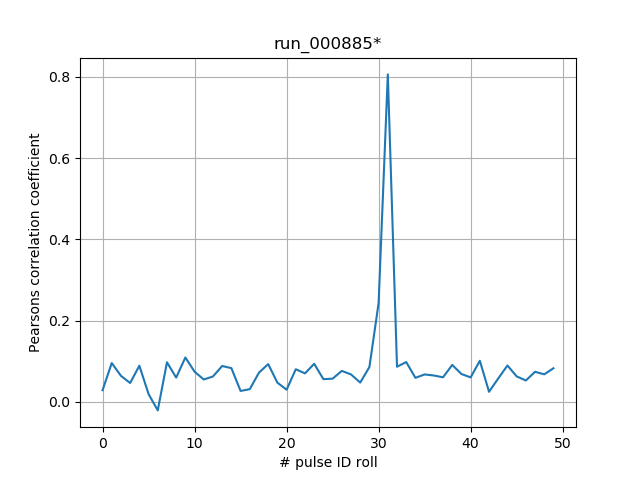

In [129]:
from scipy.stats.stats import pearsonr

DataFluoJF_shot_rot = np.copy(DataFluoJF_shot)
corr = []

for i in range (50):
    DataFluoJF_shot_rot = np.roll(DataFluoJF_shot, i, axis = 0)
    corr.append(pearsonr(IzeroFEL_shot,DataFluoJF_shot_rot)[0])
corr = np.asarray(corr)
print (np.argmax(corr))

plt.figure()
plt.title(f.split('.')[0])
plt.plot(corr)
plt.ylabel('Pearsons correlation coefficient')
plt.xlabel('# pulse ID roll')
plt.grid()
plt.show()

## Izero vs Izero

Energy = 7118.0652097155025 eV
Median value Izero 117 (all) = 0.623749777674675
Median value Izero 122 (all) = 0.1560030896216631
correlation = 0.9981097600389135


<IPython.core.display.Javascript object>


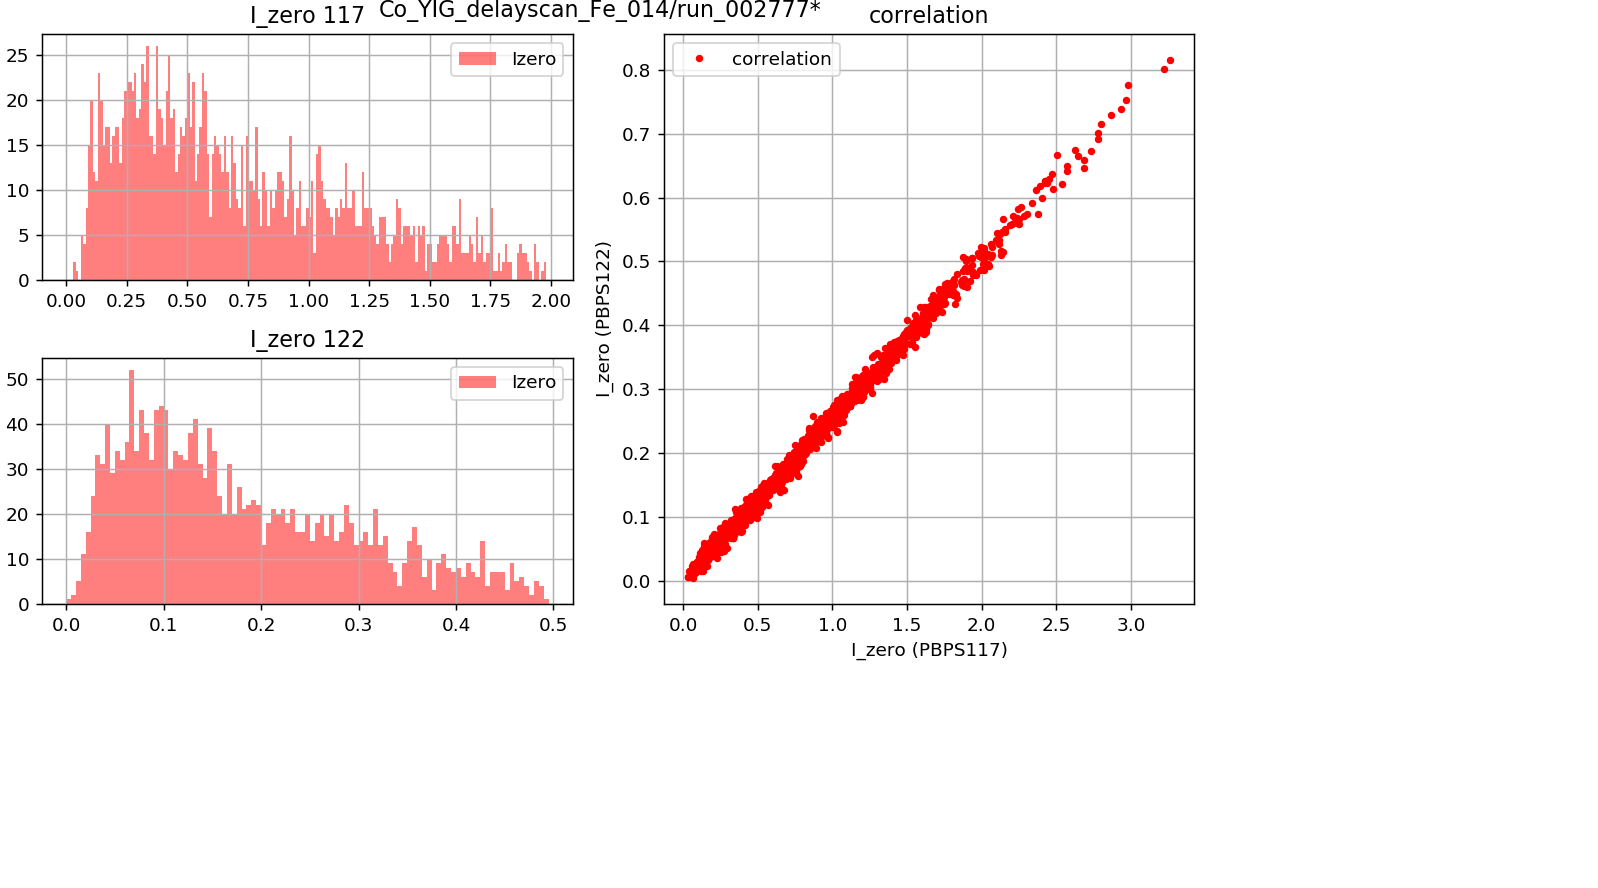

In [30]:
IzeroFEL_shot1 = IzeroFEL117_shot.copy()
IzeroFEL_shot2 = IzeroFEL122_shot.copy()

print ("Energy = {} eV".format(np.median(Energy_shot)))
print ("Median value Izero 117 (all) = {}".format(np.median(IzeroFEL_shot1)))
print ("Median value Izero 122 (all) = {}".format(np.median(IzeroFEL_shot2)))
print ("correlation = {}".format(pearsonr(IzeroFEL_shot1,IzeroFEL_shot2)[0]))

fig = plt.figure(constrained_layout=True, figsize=(9,5))
plt.suptitle(scan_name +"/"+ f.split('.')[0], y = 1)
gs = fig.add_gridspec(2, 2)

f_ax1 = fig.add_subplot(gs[0, :-1])
f_ax1.set_title('I_zero 117')
plt.hist(IzeroFEL_shot1, bins =np.arange(0,2,0.01), facecolor='red', label="Izero", alpha=0.5)
plt.grid()
plt.legend(loc="best")

f_ax2 = fig.add_subplot(gs[1, :-1])
f_ax2.set_title('I_zero 122')
plt.hist(IzeroFEL_shot2, bins =np.arange(0,0.5,0.005), facecolor='red', label='Izero', alpha=0.5)
plt.grid()
plt.legend(loc="best")

f_ax3 = fig.add_subplot(gs[0:, 1])
f_ax3.set_title('correlation')
plt.plot(IzeroFEL_shot1, IzeroFEL_shot2, color = 'red',  linestyle='None', label='correlation',marker='.')
plt.grid()
plt.legend(loc="best")
plt.xlabel("I_zero (PBPS117)")
plt.ylabel ("I_zero (PBPS122)")

plt.show()

In [5]:
scan_name ="Co_YIG_monoscan_008"
DIR_json = "/sf/alvra/data/p18741/raw/scan_info/"
DIR = "/sf/alvra/data/p18741/raw/" + scan_name + "/"             #use this for a scan

#######################################################################

!ls -lah -rt $DIR | grep h5
!hostname

-rw-r--r--.  1 root p18741 4.9G Dec  9 00:08 run_000890.JF04T01V01.h5
-rw-r--r--.  1 root p18741 4.9G Dec  9 00:08 run_000890.JF10T01V01.h5
-rw-r--r--.  1 root p18741 4.9G Dec  9 00:09 run_000891.JF10T01V01.h5
-rw-r--r--.  1 root p18741 4.9G Dec  9 00:09 run_000891.JF04T01V01.h5
-rw-r--r--.  1 root p18741 603M Dec  9 00:10 run_000890.BSREAD.h5
-rw-r--r--.  1 root p18741 4.9G Dec  9 00:10 run_000892.JF04T01V01.h5
-rw-r--r--.  1 root p18741 4.9G Dec  9 00:10 run_000892.JF10T01V01.h5
-rw-r--r--.  1 root p18741  58M Dec  9 00:11 run_000890.BSDATA.h5
-rw-r--r--.  1 root p18741 603M Dec  9 00:11 run_000891.BSREAD.h5
-rw-r--r--.  1 root p18741  22M Dec  9 00:11 run_000891.BSDATA.h5
-rw-r--r--.  1 root p18741 4.9G Dec  9 00:11 run_000893.JF10T01V01.h5
-rw-r--r--.  1 root p18741 4.9G Dec  9 00:11 run_000893.JF04T01V01.h5
-rw-r--r--.  1 root p18741 4.9G Dec  9 00:12 run_000894.JF04T01V01.h5
-rw-r--r--.  1 root p18741 4.9G Dec  9 00:12 run_000894.JF10T01V01.h5
-rw-r--r--.  1 root p18741 603M Dec 

ra-c-004.psi.ch


In [10]:
f ="run_000893*.h5"
fn = DIR + f

channel_list_pp = [channel_Events, channel_Izero117, channel_Izero122,'JF04T01V01','JF10T01V01']
channel_list_all = channel_list_pp + [channel_energy]

resultsPP, results, _, _ = load_data_compact_laser_pump(channel_list_pp, channel_list_all, fn)

Energy_shot   = results[channel_energy]

IzeroFEL117_pump_shot = resultsPP[channel_Izero122].pump
IzeroFEL117_unpump_shot = resultsPP[channel_Izero122].unpump
DataFluoJFimage_pump_shot = resultsPP ['JF04T01V01']
DataFluoJFimage_unpump_shot = resultsPP ['JF04T01V01']

Auto-located gain file: /sf/alvra/config/jungfrau/gainMaps/JF04T01V01/gains.h5
Auto-located pedestal file: /sf/alvra/data/p18741/raw/JF_pedestals/run_000886.JF04T01V01.res.h5
jungfrau file: 00:11 09.12.2020
pedestal file: 22:55 08.12.2020
    mtime difference: 1:16:11.631875
Auto-located gain file: /sf/alvra/config/jungfrau/gainMaps/JF10T01V01/gains.h5
Auto-located pedestal file: /sf/alvra/data/p18741/raw/JF_pedestals/run_000886.JF10T01V01.res.h5
jungfrau file: 00:11 09.12.2020
pedestal file: 22:55 08.12.2020
    mtime difference: 1:16:06.969933
Auto-located gain file: /sf/alvra/config/jungfrau/gainMaps/JF04T01V01/gains.h5
Auto-located pedestal file: /sf/alvra/data/p18741/raw/JF_pedestals/run_000886.JF04T01V01.res.h5
jungfrau file: 00:11 09.12.2020
pedestal file: 22:55 08.12.2020
    mtime difference: 1:16:11.631875
Auto-located gain file: /sf/alvra/config/jungfrau/gainMaps/JF10T01V01/gains.h5
Auto-located pedestal file: /sf/alvra/data/p18741/raw/JF_pedestals/run_000886.JF10T01V01.res.

## Pump probe JF and Izero

In [8]:
threshold_low = 5
threshold_high = 10

pid_roll = 0

nframes = DataFluoJFimage_pump_shot.shape[0]
DataFluoJFimage_pump_shot_thr = DataFluoJFimage_pump_shot.copy()
DataFluoJFimage_unpump_shot_thr = DataFluoJFimage_unpump_shot.copy()

for j in range(nframes):
    image_pump = DataFluoJFimage_pump_shot[j,:]
    image_unpump = DataFluoJFimage_unpump_shot[j,:]
    
    image_pump_thr = DataFluoJFimage_pump_shot[j,:].copy()
    image_unpump_thr = DataFluoJFimage_unpump_shot[j,:].copy()
    
    image_pump_thr[image_pump < threshold_low] = 0
    image_unpump_thr[image_unpump < threshold_low] = 0
    
    #image_pump_thr[image_pump > threshold_high] = 0
    #image_unpump_thr[image_unpump > threshold_high] = 0
    
    DataFluoJFimage_pump_shot_thr[j,:] = image_pump_thr.copy()
    DataFluoJFimage_unpump_shot_thr[j,:] = image_unpump_thr.copy()
    

IzeroFEL_pump_raw = IzeroFEL117_pump_shot.copy()

DataFluo_pump_shot = np.roll(DataFluoJFimage_pump_shot_thr.mean(axis = 1).mean(axis = 1), pid_roll, axis = 0)
DataFluo_unpump_shot = np.roll(DataFluoJFimage_unpump_shot_thr.mean(axis = 1).mean(axis = 1), pid_roll, axis = 0)
DataFluoJF_shot_raw = DataFluoJF_shot.copy()
DataFluo_unpump_shot_raw = DataFluo_unpump_shot.copy()

print ("Energy = {} eV".format(np.median(Energy_shot)))
print ("Median value Izero (all) = {}".format(np.median(np.concatenate((IzeroFEL_pump_raw, IzeroFEL_unpump_raw), axis=0))))
print ("Median value fluo (all) = {}".format(np.median(np.concatenate((DataFluo_pump_shot_raw, DataFluo_unpump_shot_raw), axis=0))))

fig = plt.figure(constrained_layout=True, figsize=(9,5))
plt.suptitle(scan_name +"/"+ f.split('.')[0], y = 1)
gs = fig.add_gridspec(2, 2)

f_ax1 = fig.add_subplot(gs[0, :-1])
f_ax1.set_title('Fluo')
plt.hist(DataFluo_pump_shot, bins =np.arange(-0.5,0.85,0.01), facecolor='red', label="pump", alpha=0.5)
plt.hist(DataFluo_unpump_shot, bins =np.arange(-0.5,0.85,0.01), facecolor='grey', label="unpump", alpha=0.5)
plt.grid()
plt.legend(loc="best")

f_ax2 = fig.add_subplot(gs[1, :-1])
f_ax2.set_title('I_zero')
plt.hist(IzeroFEL_pump_shot, bins =np.arange(0,0.85,0.01), facecolor='red', label='pump', alpha=0.5)
plt.hist(IzeroFEL_unpump_shot, bins =np.arange(0,0.85,0.01), facecolor='blue', label ='unpump', alpha=0.5)
plt.grid()
plt.legend(loc="best")

f_ax3 = fig.add_subplot(gs[0:, 1])
f_ax3.set_title('correlation')
plt.plot(IzeroFEL_pump_shot, DataFluo_pump_shot, color = 'red',  linestyle='None', label='pump',marker='.')
plt.plot(IzeroFEL_unpump_shot, DataFluo_unpump_shot, color = 'blue',  linestyle='None', label='unpump',marker='.')
plt.grid()
plt.legend(loc="best")
plt.xlabel("I_zero (PBPS122)")
plt.ylabel ("Fluorescence (PIPS)")

plt.show()

AttributeError: 'PPData' object has no attribute 'shape'